In [29]:
import numpy as np
import pandas as pd
from keras.layers import Dense,Dropout,GaussianNoise
import matplotlib.pyplot as plt
from keras.optimizers import Adam,rmsprop
from keras.models import Sequential,Model
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn import metrics
from random import sample
import time
def purity_score(y_true, y_pred):
    # compute contingency matrix (also called confusion matrix)
    contingency_matrix = metrics.cluster.contingency_matrix(y_true, y_pred)
    # return purity
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix)


In [2]:
expr = pd.read_csv('pancreas_3groups.csv',index_col=0)


In [5]:
X = expr.values[:,:-1]
Y = expr.values[:,-1]
Y = pd.factorize(Y)[0]
K = len(np.unique(Y))
print('{} different cell types'.format(K))
ncell = X.shape[0]
ngene = X.shape[1]
X = X.astype('float')
print('proportion of 0s: {}'.format(np.mean(X==0)))
print('{} cells and {} genes'.format(ncell,ngene))

3 different cell types
proportion of 0s: 0.4175160349854227
1715 cells and 250 genes


In [6]:
libs = X.sum(axis = 1)
norm_factor = np.diag(np.median(libs)/libs)
X_norm = np.dot(norm_factor,X)
X_norm = np.log2(X_norm + 1.)
X_norm = StandardScaler().fit_transform(X_norm)

In [10]:
tsne = TSNE(n_components = 2,random_state=1)
T_sne_true = tsne.fit_transform(X_norm)

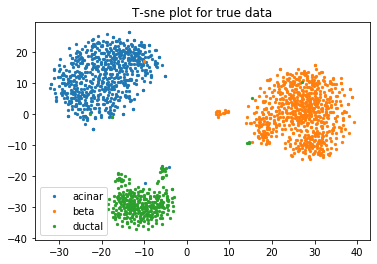

In [12]:
unique_class = np.unique(expr.values[:,-1])
YY = expr.values[:,-1]
for i in range(K):
    plt.scatter(T_sne_true[YY==unique_class[i],0],
                T_sne_true[YY==unique_class[i],1], 
                s=5,label = unique_class[i] )
plt.title('T-sne plot for true data')
plt.legend()

#### create a noised version by adding random dropout and Gaussian noise

In [27]:
p = 0.3

X_ob = X_ob + np.random.normal(0,1,[ncell,ngene])

zero_mask = np.random.binomial(1,1-p,[ncell,ngene])
X_ob = X.copy()
X_ob = X_ob *zero_mask

X_ob[X_ob<0] = 0
np.mean(X_ob==0)

0.5922495626822157

In [36]:
libs = X_ob.sum(axis = 1)
norm_factor = np.diag(np.median(libs)/libs)
X_ob_norm = np.dot(norm_factor,X_ob)
X_ob_norm = np.log2(X_ob_norm + 1.)
X_ob_norm = StandardScaler().fit_transform(X_norm)

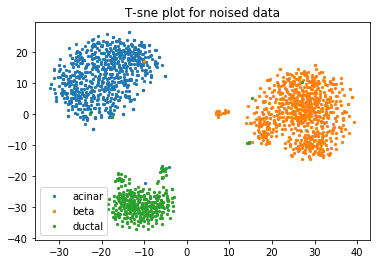

In [38]:
tsne = TSNE(n_components=2,random_state=1)
T_sne_noise = tsne.fit_transform(X_ob_norm)
unique_class = np.unique(expr.values[:,-1])
YY = expr.values[:,-1]
for i in range(K):
    plt.scatter(T_sne_noise[YY==unique_class[i],0],
                T_sne_noise[YY==unique_class[i],1], 
                s=5,label = unique_class[i] )
plt.title('T-sne plot for noised data')
plt.legend()

#### autoencoder 

In [32]:
t = time.time()
X_imp = np.zeros(shape=(ncell,ngene))
runs = 20
n_input = X.shape[1]
for i in range(runs):
    
    
    #build autoencoder model
    
    model1 = Sequential()
    model1.add(GaussianNoise(1))

    model1.add(Dense(128,activation = 'relu',
                input_shape = (n_input,)))
    
    model1.add(Dense(64,activation = 'relu',
                name = 'bottleneck'))
    
    model1.add(Dense(128,activation='relu'))
    model1.add(Dense(n_input,activation = 'relu'))
    #model training
    model1.compile(loss='mean_squared_error',
                   optimizer=rmsprop())
    model1.fit(X_ob,X_ob,batch_size=32,epochs=200,
           verbose=0,shuffle=True)
    Denoise = Model(model1.input,model1.output)
    X_imp = X_imp + Denoise.predict(X_ob)
    del model1, Denoise
X_imp = X_imp/runs
print('elapse time: {}'.format(time.time()-t))

elapse time: 639.4520633220673


In [34]:
libs = X_imp.sum(axis = 1)
norm_factor = np.diag(np.median(libs)/libs)
X_imp_norm = np.dot(norm_factor,X_imp)
X_imp_norm = np.log2(X_imp_norm + 1.)
for i in range(ngene):
    if np.std(X_imp_norm[:,i])!=0:
        X_imp_norm[:,i] = (X_imp_norm[:,i]-np.mean(X_imp_norm[:,i]))/np.std(X_imp_norm[:,i])

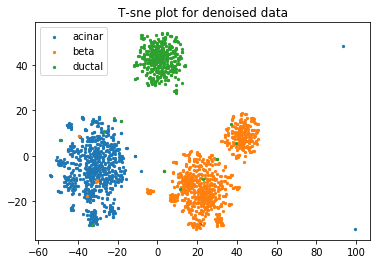

In [35]:
tsne = TSNE(n_components=2,random_state=1)
T_sne_imp = tsne.fit_transform(X_imp_norm)
unique_class = np.unique(expr.values[:,-1])
YY = expr.values[:,-1]
for i in range(K):
    plt.scatter(T_sne_imp[YY==unique_class[i],0],
                T_sne_imp[YY==unique_class[i],1], 
                s=5,label = unique_class[i] )
plt.title('T-sne plot for denoised data')
plt.legend()